<a href="https://colab.research.google.com/github/fweilun/momentum/blob/main/momentum_strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="markdown-google-sans">
  <h1>Introduction Of Strategy</h1>
</div>
This strategy mainly contains two part. The first part is extracting the signal, and the other part is to implement some transformation on the signal to make it perform better.

## risk-adjusted return
We first intruduct the risk-adjusted return $U_n$.

$$U_{n} = \frac{X_{n} - X_{n-1}}{\hat{\sigma}_{n-1}}, \quad \hat{\sigma}_{n} = E_n\left[ (X_{n+1} - X_n)^2 \right]^{1/2}$$

By the definition, comparing to original return function,  the method makes the return lower when volatility is high.

## signal
For the first part, we define $\phi_n$ to be signal at time n where $a_j$ represents weights on EMA and $U_{n}$ represents risk-adjusted return

$$\phi_n = \sum_{j=0}^{\infty} a_j U_{n-j}.$$

Since $\infty$ is irrealizable on programming, we fix a rolling window of length $L_1$, and replace $\infty$ by $L_1$, then we get the following function.

$$\phi_n = \sum_{j=0}^{L_{1}} a_j U_{n-j}.$$

In [ ]:
# import all packages
import sys, datetime, math
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import datetime, math
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
from ipywidgets import interact
from scipy.stats import norm,skew
from google.colab import drive

In [ ]:
class decay_function:
    @classmethod
    def EMA(cls,n,M):
        alpha = 1-n**(-1)

        EMA_scalar = (1-alpha**2)**0.5
        f = lambda j:EMA_scalar*alpha**j
        result = np.array([f(j) for j in range(M)])
        return result/sum(result)

    @classmethod
    def EMA2(cls,n1,n2,M):
        alpha = 1-n1**(-1)
        beta = 1-n2**(-1)
        c = (((1-alpha**2)*(1-beta**2)*(1-alpha*beta)/(1+alpha*beta))**0.5)/(alpha-beta)
        EMA2_scalar = lambda j:c*(alpha**j-beta**j)
        result = np.array([EMA2_scalar(j+1) for j in range(M)])
        return result/sum(result)

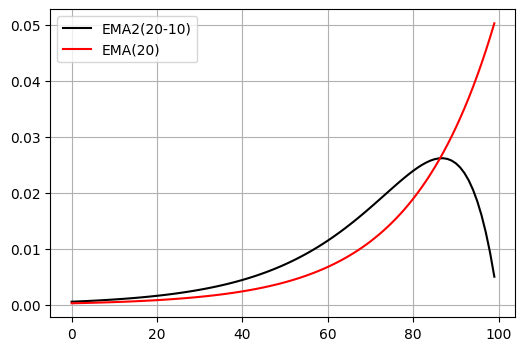

In [ ]:
plt.figure(figsize=(6,4))
ax1 = pd.Series(decay_function.EMA2(10,20,100)[::-1]).plot(label="EMA2(20-10)",color="black")
pd.Series(decay_function.EMA(20,100)[::-1]).plot(ax=ax1,label="EMA(20)",color="red")
ax1.legend()
plt.grid()

#Three types of activation function.

In [ ]:
class activate:
        reverting = lambda x,c:(1+2*c**2)**(3/4)*x*np.exp(-(c*x)**2/2)
        sigmoid = lambda x,c:(((2/np.pi)*math.atan(c**2/(1+2*c**2)**0.5))**(-0.5))*(2*(norm.cdf(x*c))-1)
        linear = lambda x,c:x


# this is used to produce the graph as it's name says
class graph_maker:
  def __init__(self, name):
    self.name = name

  def load_function(self, func):
    self.func = func

  def exe(self):
    def plot_dynamic_graph(c=1.0):
      x = np.linspace(-5, 5, 400)
      y = eval(self.func)

      plt.figure(figsize=(6,4))
      plt.plot(x, y)
      plt.title(self.name)
      plt.xlabel('x')
      plt.ylabel('y')
      plt.grid(True)
      plt.show()

    interact(plot_dynamic_graph, c=(0, 1.5, 0.05))


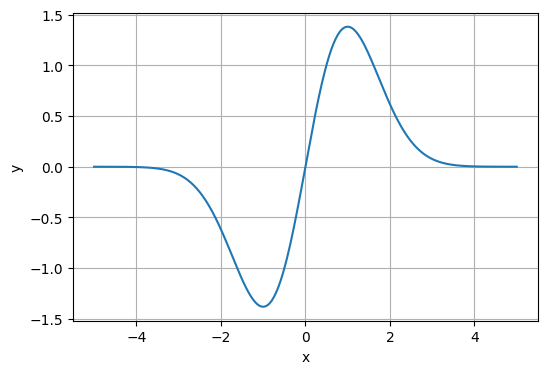

In [140]:
# graph = graph_maker("reverting function")
c = 1
x = np.linspace(-5, 5, 400)
y = eval("(1+2*c**2)**(3/4)*x*np.exp(-(c*x)**2/2)")
plt.figure(figsize=(6,4))
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

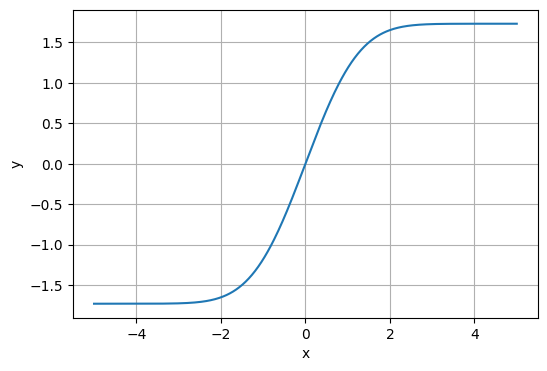

In [141]:

c = 1
x = np.linspace(-5, 5, 400)
y = eval("(((2/np.pi)*math.atan(c**2/(1+2*c**2)**0.5))**-0.5)*(2*(norm.cdf(x*c))-1)")
plt.figure(figsize=(6,4))
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

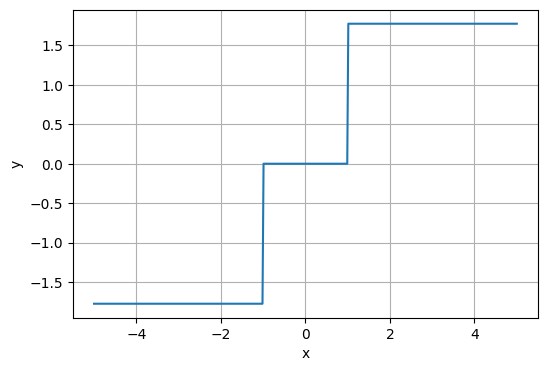

In [142]:

c = 1
x = np.linspace(-5, 5, 400)
y = eval("(2*norm.cdf(-c))**(-1/2) * (abs(x)-c>0)*np.sign(x)")
plt.figure(figsize=(6,4))
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

In [144]:

class momentum_model:

    class activate:
        reverting = lambda x,c:(1+2*c**2)**(3/4)*x*np.exp(-(c*x)**2/2)
        sigmoid = lambda x,c:(((2/np.pi)*math.atan(c**2/(1+2*c**2)**0.5))**(-0.5))*(2*(norm.cdf(x*c))-1)
        linear = lambda x,c:x

    def __init__(self,name=None) -> None:
        self.name = name
        self.df = None
        self.args =  {
            "window_size":(16,6),
            "signal_len":32,
            "activate":"linear",
            "c":1,
            "lag":30
        }
        # lag is for volatility lag
        # signal length is moving average line of (an*U_{n+1}) to compute the signal

        self.offset = self.args["signal_len"]+self.args["lag"]+22

    def load_data(self):
        # /content/sample_data/Binance_BTCUSDT_1h.csv
        # df = pd.read_csv(filepath).set_index("Date").sort_index(ascending=True)
        df = pd.read_csv("sample_data/Binance_BTCUSDT_1h.csv").set_index("Date").sort_index(ascending=True)
        self.date = pd.to_datetime(pd.Series(df.index))
        df.columns = [str.lower(s) for s in df.columns]
        self.price = df["close"]
        self.df = pd.DataFrame(df["close"])
        # self.date = pd.to_datetime(self.df.index)

    def position_update(self):
        df = pd.DataFrame(self.price)
        df = df.assign(d_price = df["close"].diff())
        df = df.assign(vol = abs(df["d_price"]).rolling(self.args["lag"]).std())
        df = df.assign(Un = df["d_price"]/df["vol"].shift(1)).dropna()

        signal_len = self.args["signal_len"]
        ema2 = decay_function.EMA2(10,20,signal_len)[::-1]

        df = df.assign(Sn = pd.Series([0 for _ in range(signal_len-1)] + [np.dot(df["Un"][i:i+signal_len], ema2) for i in range(len(df)-signal_len+1)],index=df.index))

        if self.args["activate"] == "sigmoid":
            activate_f = self.activate.sigmoid
        elif self.args["activate"] == "reverting":
            activate_f = self.activate.reverting
        elif self.args["activate"] == "linear":
            activate_f = self.activate.linear

        df["Sn"] = pd.Series([activate_f(x=s,c=self.args["c"]) for s in df["Sn"]],index=df.index)
        self.df = df


    def setting(self,**args):
        self.args = {**self.args, **args}
        self.offset = self.args["signal_len"]+self.args["lag"]+22
        self.data_num = len(self.price)

    def calculate_info(self,end_date,start_date="start"):

        if start_date=="start":
            start_date = self.df.index[self.offset]
        if end_date == "end":
            end_date = self.df.index.iloc[-1]

        s_n = self.df.index[self.df.index >= start_date][0]
        e_n = self.df.index[self.df.index <= end_date][-1]


        result = pd.DataFrame()
        df_window = self.df.loc[s_n:e_n]
        result["PNL"] = (df_window["Sn"]*df_window["d_price"].shift(-1)).cumsum()
        result["position"]=self.df["Sn"]
        result["price"]=df_window["close"]
        return result





# Code for using the model

In [145]:
model = momentum_model("test")
model.load_data()
model.setting(activate="sigmoid",c=0.75,window_size=(16,6),lag=10,signal_len=70)
model.position_update()
model.calculate_info(end_date="2023-10-01",start_date="2023-01-01")
# pd.read_csv(filepath).set_index("Date").sort_index(ascending=True)

,PNL,position,price
Date,,,
2023-01-01 00:00:00,-2.071828,-0.095038,16529.67
2023-01-01 01:00:00,-1.735904,-0.102416,16551.47
2023-01-01 02:00:00,-0.063187,-0.110410,16548.19
2023-01-01 03:00:00,1.347478,-0.126065,16533.04
2023-01-01 04:00:00,0.070147,-0.144168,16521.85
...,...,...,...
2023-09-30 19:00:00,4650.095494,0.256597,27020.70
2023-09-30 20:00:00,4631.657491,0.284230,27064.15
2023-09-30 21:00:00,4634.749699,0.280854,26999.28


#The relation betweeen stock price, risk-adjusted returns and signal
note that the graph of EMA2 appears to be very weird because the date index.

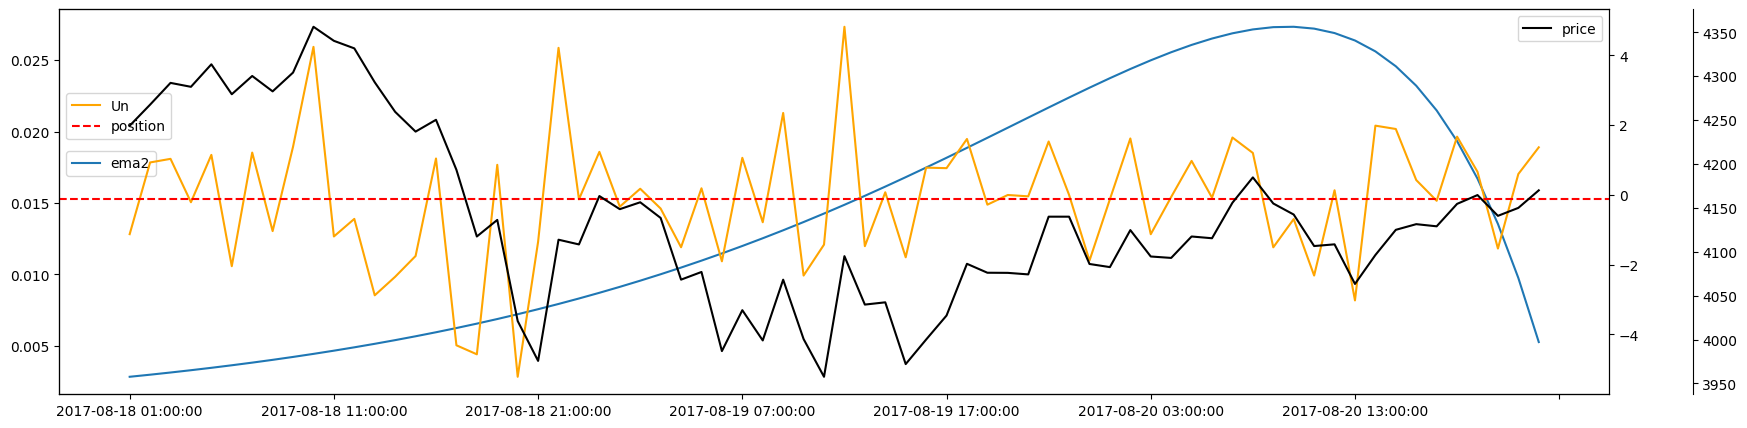

In [137]:
import ipywidgets as widgets
signal_len = 70

ema2 = decay_function.EMA2(10,20,signal_len)[::-1]

def update_plot(i, signal_len):
    plt.figure(figsize=(20, 5))
    ax1 = pd.Series(ema2).plot(label="ema2")
    ax1.legend(loc='upper left', bbox_to_anchor=(0, 0.65))
    ax2 = ax1.twinx()
    pd.Series(model.df["Un"][i:i+signal_len]).plot(ax=ax2, label="Un", color='orange')
    ax2.axhline(y= 5 * np.dot(model.df["Un"][i:i+signal_len], ema2), color='red', linestyle='--', label='position')
    ax2.legend(loc='upper left', bbox_to_anchor=(0, 0.8))
    ax3 = ax1.twinx()
    pd.Series(model.df["close"][i:i+signal_len]).plot(ax=ax3, label="price", color='black')
    ax3.spines['right'].set_position(('outward', 60))
    ax3.legend(loc='upper left', bbox_to_anchor=(0, 0.9))

    plt.legend()
    plt.show()

update_plot(10,signal_len)

# i_slider = widgets.IntSlider(value=0, min=0, max=len(model.df["Un"])-signal_len, step=1, description='i ')
# widgets.interactive(update_plot, i=i_slider, signal_len=widgets.fixed(signal_len))


                        close  d_price        vol        Un        Sn
Date                                                                 
2022-12-18 00:00:00  16747.07   -29.45  14.785522 -2.008975 -0.289591
2022-12-18 01:00:00  16713.55   -33.52  11.771178 -2.267083 -0.276508
2022-12-18 02:00:00  16731.19    17.64  10.661038  1.498576 -0.253423
2022-12-18 03:00:00  16741.02     9.83  11.411309  0.922049 -0.227102
2022-12-18 04:00:00  16764.79    23.77  11.114975  2.083021 -0.190133
...                       ...      ...        ...       ...       ...
2023-10-19 19:00:00  28750.75   103.77  59.114944  1.795116  0.462449
2023-10-19 20:00:00  28715.38   -35.37  59.793078 -0.598326  0.487468
2023-10-19 21:00:00  28604.09  -111.29  60.065760 -1.861252  0.492249
2023-10-19 22:00:00  28649.65    45.56  58.768056  0.758502  0.501780
2023-10-19 23:00:00  28713.71    64.06  53.912493  1.090048  0.521402

[7342 rows x 5 columns]


Text(0, 0.5, 'position')

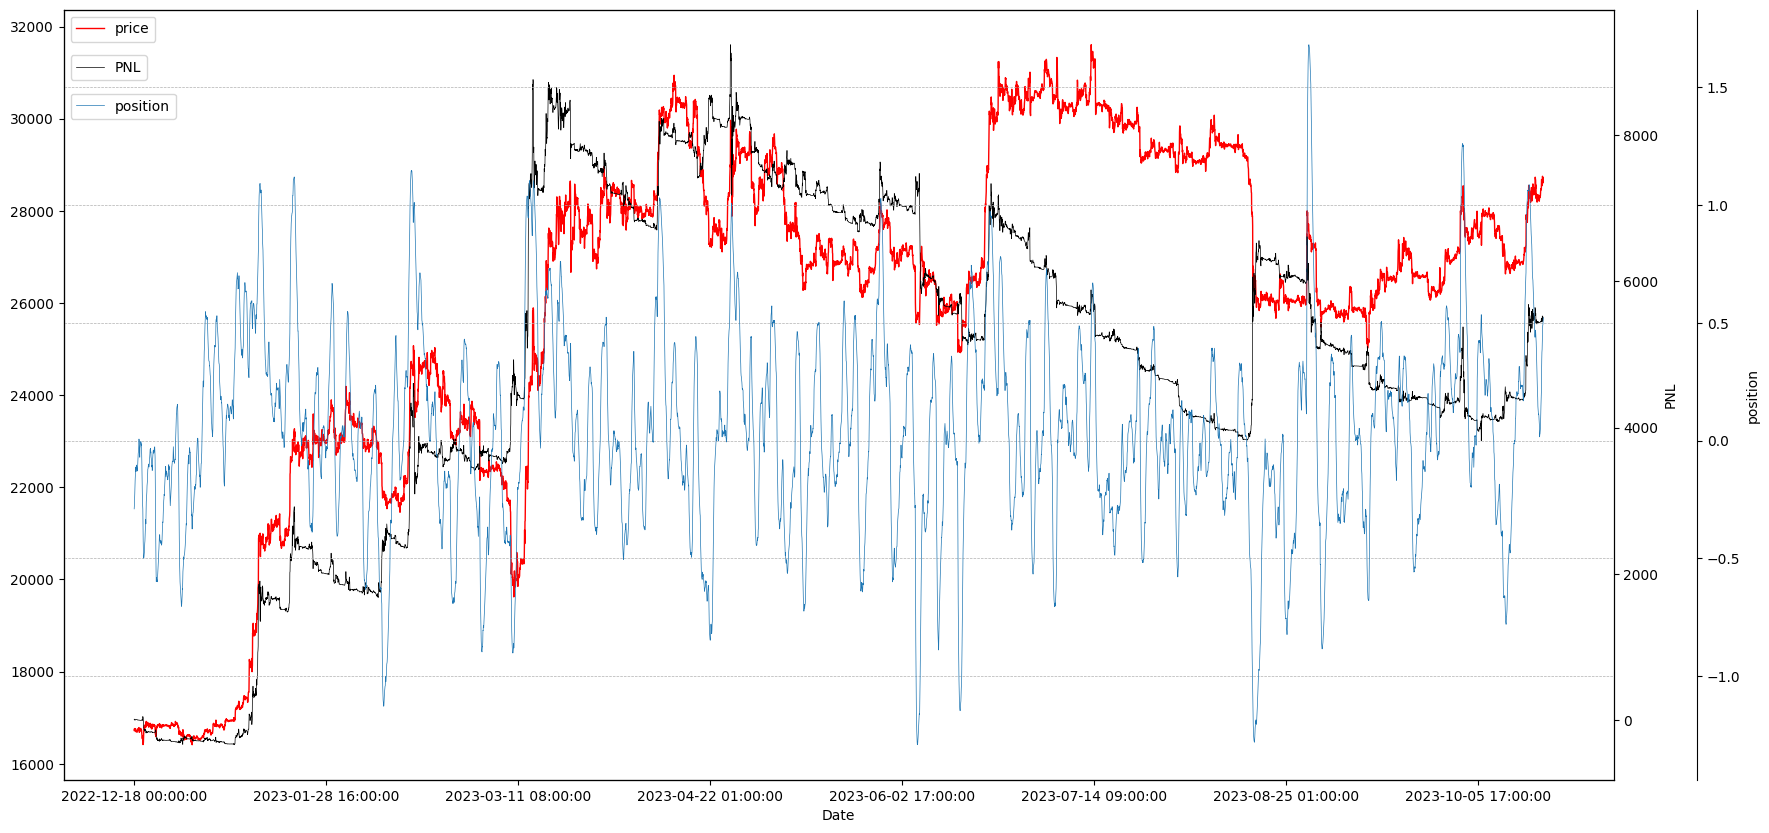

In [ ]:
result = model.calculate_info(start_date="2022-12-18",end_date="2023-12-18")

plt.figure(figsize=(20, 10))

ax1 = result["price"].plot(label='price', color='red',linestyle='-', linewidth=1)

ax1.legend(loc='upper left', bbox_to_anchor=(0, 1))
ax2 = ax1.twinx()
result["PNL"].plot(ax=ax2,label="PNL",color="black",linestyle="-",linewidth=0.5)
ax2.set_ylabel("PNL")
ax2.legend(loc='upper left', bbox_to_anchor=(0, 0.95))
ax3 = ax1.twinx()
result["position"].plot(ax=ax3,label="position",linestyle="-",linewidth=0.5)
ax3.grid(True, linestyle='--', linewidth=0.5)
ax3.legend(loc='upper left', bbox_to_anchor=(0, 0.9))
ax3.spines['right'].set_position(('outward', 60))
ax3.set_ylabel("position")




In [146]:
model = momentum_model("test")
model.load_data()
model.setting(activate="linear",c=0.75,window_size=(16,6),lag=10,signal_len=70)
model.position_update()
model.calculate_info(end_date="2023-10-01",start_date="2023-01-01")
# pd.read_csv(filepath).set_index("Date").sort_index(ascending=True)

,PNL,position,price
Date,,,
2023-01-01 00:00:00,-1.677318,-0.076941,16529.67
2023-01-01 01:00:00,-1.405335,-0.082922,16551.47
2023-01-01 02:00:00,-0.050868,-0.089404,16548.19
2023-01-01 03:00:00,1.091665,-0.102103,16533.04
2023-01-01 04:00:00,0.056811,-0.116801,16521.85
...,...,...,...
2023-09-30 19:00:00,3761.604549,0.208468,27020.70
2023-09-30 20:00:00,3746.610971,0.231133,27064.15
2023-09-30 21:00:00,3749.125220,0.228361,26999.28


Text(0, 0.5, 'position')

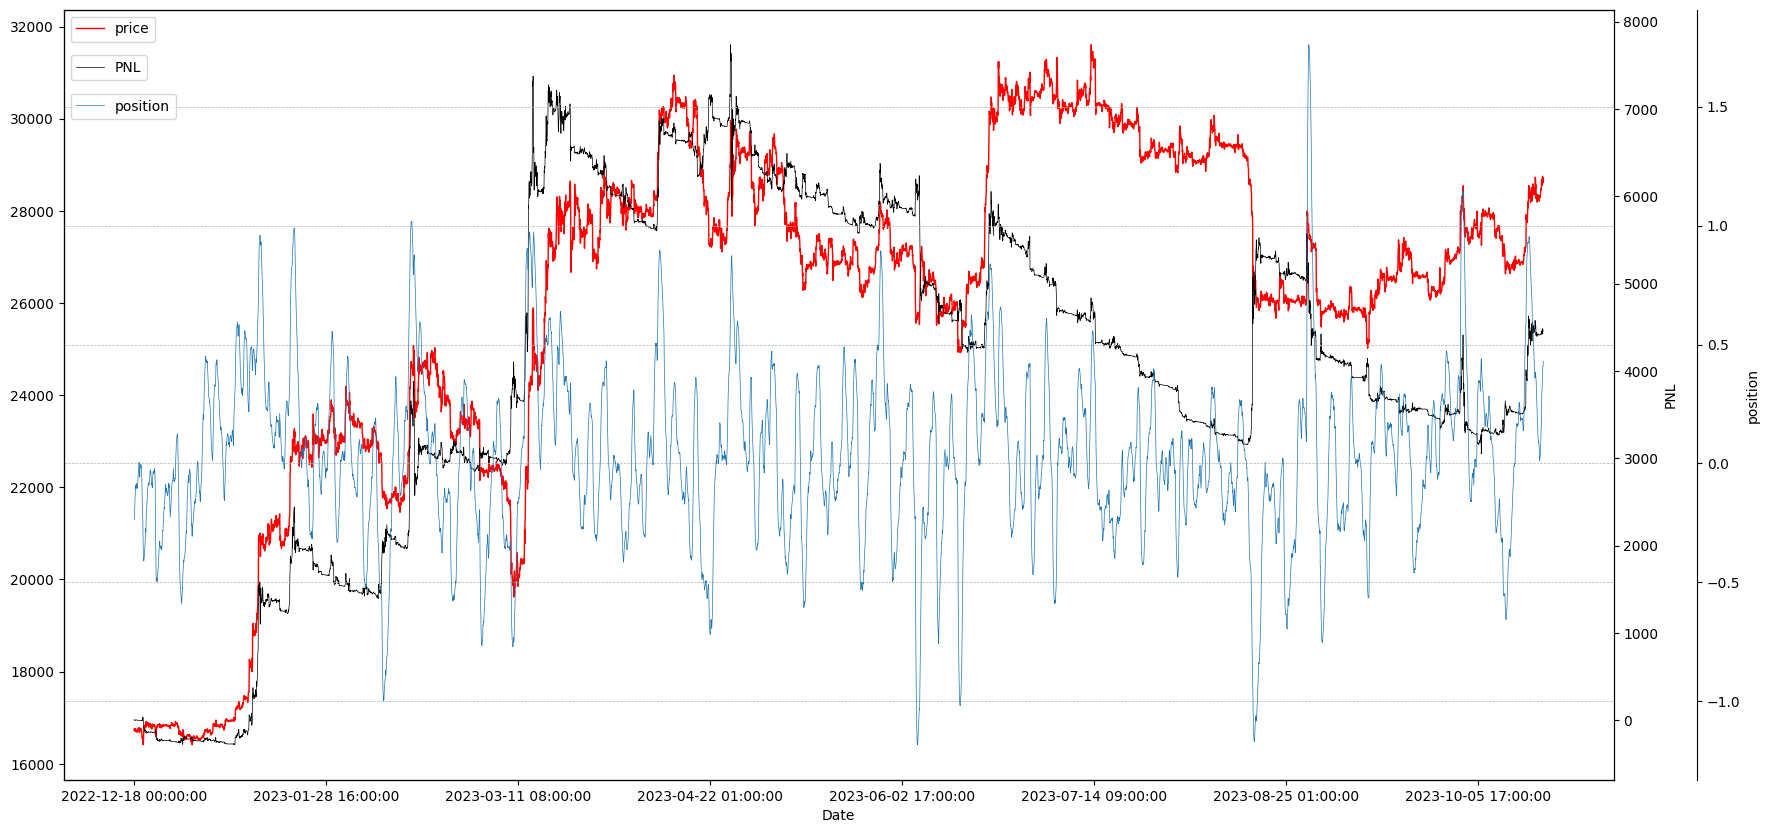

In [147]:
result = model.calculate_info(start_date="2022-12-18",end_date="2023-12-18")

plt.figure(figsize=(20, 10))

ax1 = result["price"].plot(label='price', color='red',linestyle='-', linewidth=1)

ax1.legend(loc='upper left', bbox_to_anchor=(0, 1))
ax2 = ax1.twinx()
result["PNL"].plot(ax=ax2,label="PNL",color="black",linestyle="-",linewidth=0.5)
ax2.set_ylabel("PNL")
ax2.legend(loc='upper left', bbox_to_anchor=(0, 0.95))
ax3 = ax1.twinx()
result["position"].plot(ax=ax3,label="position",linestyle="-",linewidth=0.5)
ax3.grid(True, linestyle='--', linewidth=0.5)
ax3.legend(loc='upper left', bbox_to_anchor=(0, 0.9))
ax3.spines['right'].set_position(('outward', 60))
ax3.set_ylabel("position")




In [148]:
model = momentum_model("test")
model.load_data()
model.setting(activate="reverting",c=0.75,window_size=(16,6),lag=10,signal_len=70)
model.position_update()
model.calculate_info(end_date="2023-10-01",start_date="2023-01-01")
# pd.read_csv(filepath).set_index("Date").sort_index(ascending=True)

,PNL,position,price
Date,,,
2023-01-01 00:00:00,-2.947212,-0.135193,16529.67
2023-01-01 01:00:00,-2.469440,-0.145662,16551.47
2023-01-01 02:00:00,-0.090895,-0.157000,16548.19
2023-01-01 03:00:00,1.914106,-0.179178,16533.04
2023-01-01 04:00:00,0.099709,-0.204785,16521.85
...,...,...,...
2023-09-30 19:00:00,6515.121779,0.362452,27020.70
2023-09-30 20:00:00,6489.126219,0.400733,27064.15
2023-09-30 21:00:00,6493.486935,0.396069,26999.28


Text(0, 0.5, 'position')

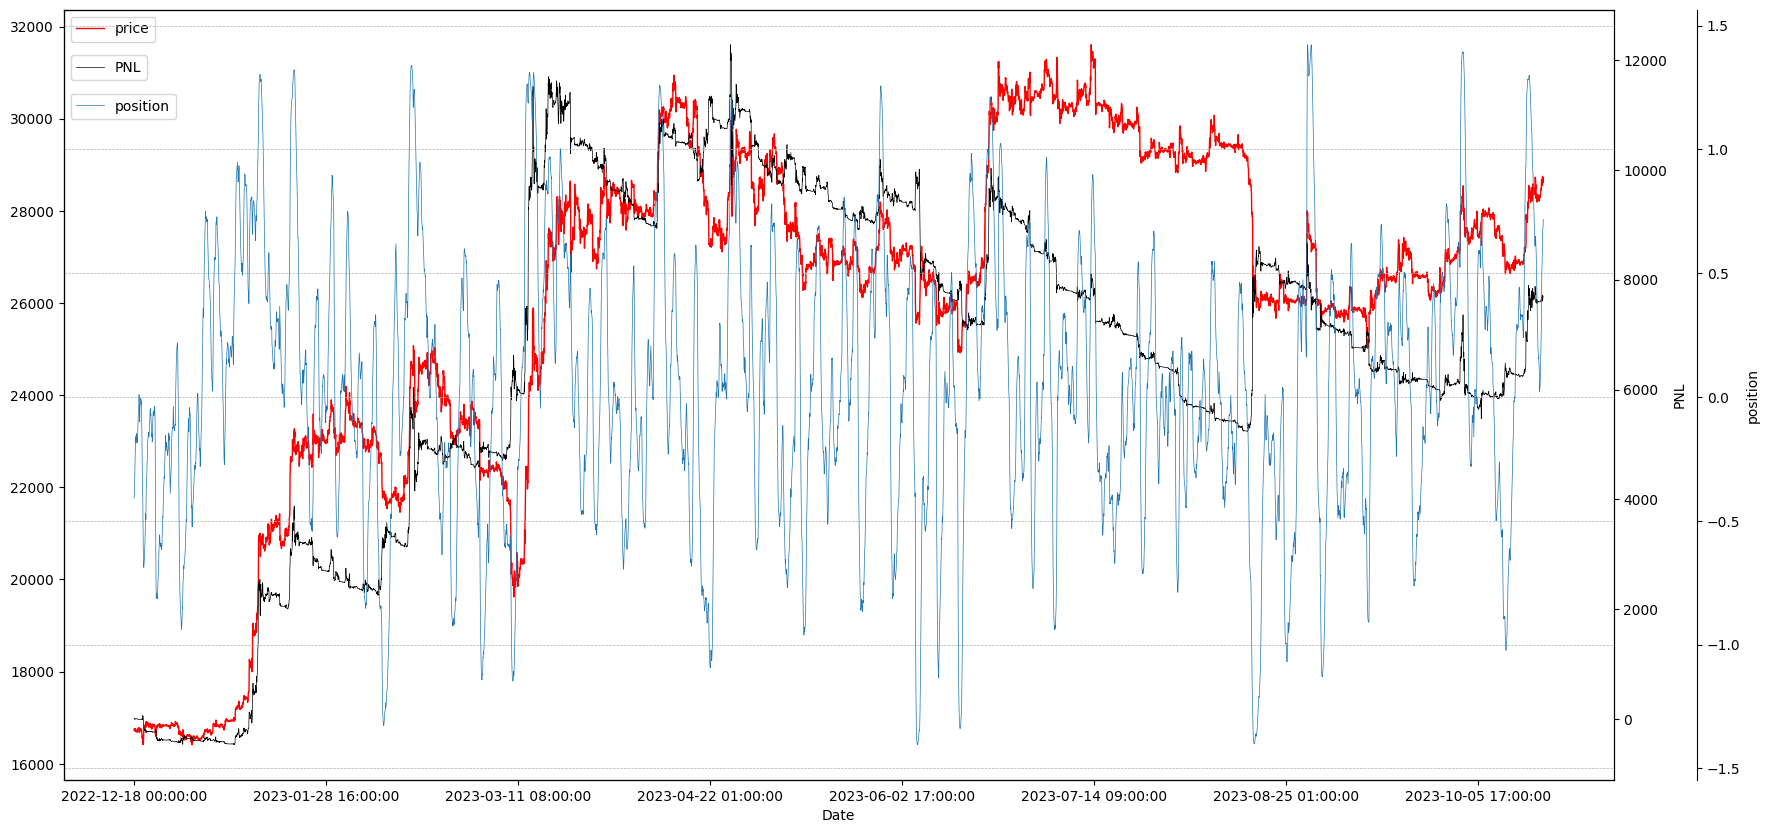

In [149]:
result = model.calculate_info(start_date="2022-12-18",end_date="2023-12-18")

plt.figure(figsize=(20, 10))

ax1 = result["price"].plot(label='price', color='red',linestyle='-', linewidth=1)

ax1.legend(loc='upper left', bbox_to_anchor=(0, 1))
ax2 = ax1.twinx()
result["PNL"].plot(ax=ax2,label="PNL",color="black",linestyle="-",linewidth=0.5)
ax2.set_ylabel("PNL")
ax2.legend(loc='upper left', bbox_to_anchor=(0, 0.95))
ax3 = ax1.twinx()
result["position"].plot(ax=ax3,label="position",linestyle="-",linewidth=0.5)
ax3.grid(True, linestyle='--', linewidth=0.5)
ax3.legend(loc='upper left', bbox_to_anchor=(0, 0.9))
ax3.spines['right'].set_position(('outward', 60))
ax3.set_ylabel("position")


